In [1]:
#!pip3 install retentioneering

In [2]:
#import sys
#sys.path.insert(0, '/Users/Daria/Dev/Retentioneering/retentioneering-tools/')
import retentioneering
import pandas as pd
import numpy as np
import io
from datetime import timedelta
import seaborn as sns

# Загрузка файла локально
для этого сохраните датасет в той же папке, в которой вы открываете ноутбук

In [3]:
data = pd.read_csv('5.4_practice_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15792 entries, 0 to 15791
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          15792 non-null  int64 
 1   event_name       15792 non-null  object
 2   event_timestamp  15792 non-null  object
dtypes: int64(1), object(2)
memory usage: 370.2+ KB


# Загрузка файла при работе в google colab

In [4]:
#from google.colab import files
#uploaded=files.upload()

In [5]:
#data = pd.read_csv(io.StringIO(uploaded['5.4_practice_dataset.csv'].decode('utf-8')),sep=',')
#data.head()

In [6]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'])
data = data.sort_values('event_timestamp')
print(len(data))
data.head()

15792


,user_id,event_name,event_timestamp
13,8150029619427326610,https://sampleonlineshop.ru/?utm_source=blog,2019-09-01 07:14:47.967690496
15,3463487194338123780,https://sampleonlineshop.ru/?utm_source=blog,2019-09-01 08:31:45.484353280
6,2163557180402591013,https://sampleonlineshop.ru/?utm_source=blog,2019-09-01 10:58:26.619910912
2,5868438858211963279,https://sampleonlineshop.ru/?utm_source=facebook,2019-09-01 14:51:00.401165312
11,8032084142377665129,https://sampleonlineshop.ru/?utm_source=facebook,2019-09-01 16:23:29.307095296


# Подготовка данных

In [7]:
user_id = 'user_id'
event_name = 'event_name'
event_time = 'event_timestamp'
source = 'utm_source'

In [8]:
data.shape

(15792, 3)

In [9]:
#обновление словаря retentioneering.config в соответствии с названиями колонок в нашем датафрейме
retentioneering.config.update({
    'event_col': event_name,
    'event_time_col': event_time,
    'user_col': user_id,
})

In [10]:
data[event_name].value_counts()

https://sampleonlineshop.ru/?utm_source=facebook                         3793
https://sampleonlineshop.ru/catalog/                                     3056
https://sampleonlineshop.ru/catalog/divani/bed_bed_frame/                2034
https://sampleonlineshop.ru/?utm_source=blog                             1645
https://sampleonlineshop.ru/catalog/pillow/podushka_anatomicheskay/      1265
https://sampleonlineshop.ru/delivery/                                    1059
https://sampleonlineshop.ru/o-kompanii                                    950
https://sampleonlineshop.ru/order/confirmation                            518
https://sampleonlineshop.ru/order/                                        485
https://sampleonlineshop.ru/order/submit                                  408
https://sampleonlineshop.ru/order/payment-option-switcher                 334
https://sampleonlineshop.ru/catalog/matrasy/sampleonlineshop_gravity/     245
Name: event_name, dtype: int64

In [11]:
# убираем из названия событий общий префикс https://sampleonlineshop.ru/
data[event_name] = data[event_name].apply(lambda x: x.split('https://sampleonlineshop.ru/')[1] if x.find('https://sampleonlineshop.ru/') != -1 else x )

# выносим признак utm_source в отдельное поле
data[source] = data[event_name].apply(lambda x: x.split('?utm_source=')[1] if x.find('?utm_source=') != -1 else '')
data[event_name] = data[event_name].apply(lambda x: x.split('?utm_source=')[1] if x.find('?utm_source=') != -1 else x)

#меняем название целевого события на 'passed'
data[event_name] = data[event_name].apply(lambda x: 'passed' if x=='order/submit' else x)

# выделим списки пользователей пришедших по разным каналам
users_facebook = set(data[data[source] == 'facebook'][user_id])
users_blog = set(data[data[source] == 'blog'][user_id])

data[source]= data.apply(lambda x: 'facebook' if (x[user_id] in users_facebook) else 'blog', axis = 1)

In [12]:
data[event_name].value_counts()

facebook                                     3793
catalog/                                     3056
catalog/divani/bed_bed_frame/                2034
blog                                         1645
catalog/pillow/podushka_anatomicheskay/      1265
delivery/                                    1059
o-kompanii                                    950
order/confirmation                            518
order/                                        485
passed                                        408
order/payment-option-switcher                 334
catalog/matrasy/sampleonlineshop_gravity/     245
Name: event_name, dtype: int64

# Событие lost
теперь всем пользователям, кто не купил (не было события 'order/submit'), мы добавляем событие "lost"

In [15]:
def add_lost_event(df,seconds_to_add=1):
    #список пользователей, у которых было событие покупки
    passed_ids = list(df[df[event_name]=='passed'][user_id])
    #отфильтруем все события с несконвертированными пользователсями
    lost_df = df[~df[user_id].isin(passed_ids)]
    #сгруппируем датасет по пользователям и возьмем последнее по времени событие, прибавим к нему 1 секунду
    lost_df = lost_df.groupby([user_id,'utm_source'])[[event_time]].max().reset_index()
    
    lost_df[event_time] = lost_df[event_time].apply(lambda x: x + timedelta(seconds=seconds_to_add))
    #переименуем событие в lost у всех строк
    lost_df[event_name] = 'lost'
    #склеим 2 датафрейма
    df_with_lost = pd.concat([df,lost_df])
    
    return df_with_lost

In [16]:
#применяем функцию выше и получаем датафрейм, где у всех несконвертированных пользователей добавилось новое событие "lost"
data_with_lost = add_lost_event(data)
data_with_lost

,user_id,event_name,event_timestamp,utm_source
13,8150029619427326610,blog,2019-09-01 07:14:47.967690496,blog
15,3463487194338123780,blog,2019-09-01 08:31:45.484353280,blog
6,2163557180402591013,blog,2019-09-01 10:58:26.619910912,blog
2,5868438858211963279,facebook,2019-09-01 14:51:00.401165312,facebook
11,8032084142377665129,facebook,2019-09-01 16:23:29.307095296,facebook
...,...,...,...,...
3391,9211184395632652112,lost,2019-11-01 13:42:35.970815488,facebook
3392,9219484628138534504,lost,2019-10-30 02:24:56.885488128,facebook
3393,9222385022196670624,lost,2019-10-21 03:54:38.494139392,blog
3394,9222501761129383702,lost,2019-09-18 21:35:52.517752576,facebook


In [17]:
# обратим внимание на соотношение пользователей по РК
data_with_lost[source].value_counts()

facebook    12816
blog         6372
Name: utm_source, dtype: int64

 Посмотрим траекторию одного пользователя

In [19]:
user=9222385022196670624
single_user_trajectory = data_with_lost[data_with_lost.user_id == user]
single_user_trajectory

,user_id,event_name,event_timestamp,utm_source
8714,9222385022196670624,blog,2019-10-10 03:17:05.831971584,blog
9518,9222385022196670624,catalog/divani/bed_bed_frame/,2019-10-11 15:51:24.045220608,blog
9871,9222385022196670624,catalog/divani/bed_bed_frame/,2019-10-12 08:43:03.380238592,blog
10048,9222385022196670624,catalog/divani/bed_bed_frame/,2019-10-14 10:18:40.455842816,blog
10574,9222385022196670624,catalog/divani/bed_bed_frame/,2019-10-15 08:28:20.120013568,blog
11291,9222385022196670624,catalog/divani/bed_bed_frame/,2019-10-16 19:17:20.757519360,blog
11591,9222385022196670624,catalog/divani/bed_bed_frame/,2019-10-19 01:19:58.193749760,blog
12244,9222385022196670624,order/,2019-10-21 03:54:37.494139392,blog
3393,9222385022196670624,lost,2019-10-21 03:54:38.494139392,blog


Состав событий


In [25]:
data_with_lost[event_name].drop_duplicates()

13                                           blog
2                                        facebook
83                                       catalog/
84                  catalog/divani/bed_bed_frame/
81                                     o-kompanii
108                                     delivery/
310       catalog/pillow/podushka_anatomicheskay/
367     catalog/matrasy/sampleonlineshop_gravity/
461                                        order/
536                            order/confirmation
817                                        passed
1008                order/payment-option-switcher
0                                            lost
Name: event_name, dtype: object

# Граф

Посмотрим расположение событий в виде графа

Проверяем, что все события присутствуют, корректно отображаются. 

Однако, сделать вывод о проблемном месте по данной картине затруднительно

In [21]:
data_with_lost.rete.plot_graph(
                     #weight_col='user_id',# None(default), 'column' e.g.'client_id'
                     norm_type='node',#'full'(default), None(absolute values), 'node'
                     targets={'passed':'green',
                                'lost':'red'
                               },
                     thresh=0.01,
                    );

In [27]:
data_with_lost.rete.plot_graph(
                     #weight_col='user_id',# None(default), 'column' e.g.'client_id'
                     norm_type='node',#'full'(default), None(absolute values), 'node'
                     targets={'passed':'green',
                                'lost':'red',
                              'facebook':'source',
                              'blog':'source'
                               },
                     thresh=0.01,
                    );

Какие переходы между событиями есть в наших данных:


In [28]:
edgelist = data_with_lost.rete.get_edgelist(weight_col='user_id', norm_type=None, edge_attributes='users_nunique')
edgelist.sort_values('users_nunique', ascending=False).head(5)

,event_name,next_event_name,users_nunique
35,facebook,catalog/,1610
9,catalog/,catalog/pillow/podushka_anatomicheskay/,881
38,facebook,lost,837
2,blog,catalog/divani/bed_bed_frame/,594
11,catalog/,lost,590


## Фреймворк

Анализировать поступенчато, анализируя этапы CJM по конкретной вершине:
- смотря входящие в вершину ребра
- смотря исходящие из вершины ребра

Удобно смотреть в сортировке по абсолютным числам веса перехода

In [30]:
edgelist.query('next_event_name == "catalog/"').sort_values('users_nunique', ascending=False).head(5)

,event_name,next_event_name,users_nunique
35,facebook,catalog/,1610
24,catalog/pillow/podushka_anatomicheskay/,catalog/,288
13,catalog/divani/bed_bed_frame/,catalog/,278
1,blog,catalog/,148
6,catalog/,catalog/,95


In [31]:
edgelist.query('event_name == "catalog/"').sort_values('users_nunique', ascending=False).head(5)

,event_name,next_event_name,users_nunique
9,catalog/,catalog/pillow/podushka_anatomicheskay/,881
11,catalog/,lost,590
7,catalog/,catalog/divani/bed_bed_frame/,426
8,catalog/,catalog/matrasy/sampleonlineshop_gravity/,234
10,catalog/,delivery/,221


In [34]:
edgelist.query('next_event_name == "order/confirmation"').sort_values('users_nunique', ascending=False).head(5)

,event_name,next_event_name,users_nunique
57,order/payment-option-switcher,order/confirmation,220
28,catalog/pillow/podushka_anatomicheskay/,order/confirmation,131
17,catalog/divani/bed_bed_frame/,order/confirmation,101
22,catalog/matrasy/sampleonlineshop_gravity/,order/confirmation,62


In [32]:
edgelist.query('event_name == "delivery/"').sort_values('users_nunique', ascending=False).head(5)

,event_name,next_event_name,users_nunique
33,delivery/,lost,347
32,delivery/,facebook,295
34,delivery/,o-kompanii,100
30,delivery/,catalog/,91
31,delivery/,delivery/,85


## Матрица связности

Построим матрицу переходов пользователей между событиями (матрицу связности)

In [29]:
df = data_with_lost.rete.get_adjacency(weight_col='user_id', norm_type=None)

def rotateheader():
    return  [
     dict(selector="th", props=[("font-size", "75%"),
                            ("text-align", "right")
                          ]),
        dict(selector="th.col_heading", props=[("font-size", "75%"),
                            ("text-align", "left"),
                            ("transform", "translate(0%,-30%) rotate(-10deg)")
                          ]),
             dict(selector="caption", props=[("caption-side", "bottom")])
                ]

cm = sns.light_palette("green", as_cmap=True)
print("\n\n\n")
df.style.background_gradient(cmap=cm).set_table_styles(rotateheader()).set_caption(" .")

,blog,catalog/,catalog/divani/bed_bed_frame/,delivery/,lost,o-kompanii,catalog/matrasy/sampleonlineshop_gravity/,catalog/pillow/podushka_anatomicheskay/,order/,order/confirmation,facebook,order/payment-option-switcher,passed
blog,150.000000,148.000000,594.000000,152.000000,348.000000,158.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/,0.000000,95.000000,426.000000,221.000000,590.000000,211.000000,234.000000,881.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/divani/bed_bed_frame/,0.000000,278.000000,409.000000,0.000000,473.000000,0.000000,0.000000,0.000000,228.000000,101.000000,0.000000,0.000000,0.000000
delivery/,79.000000,91.000000,0.000000,85.000000,347.000000,100.000000,0.000000,0.000000,0.000000,0.000000,295.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
o-kompanii,76.000000,84.000000,0.000000,181.000000,198.000000,82.000000,0.000000,0.000000,0.000000,0.000000,261.000000,0.000000,0.000000
catalog/matrasy/sampleonlineshop_gravity/,0.000000,44.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,50.000000,62.000000,28.000000,0.000000,0.000000
catalog/pillow/podushka_anatomicheskay/,122.000000,288.000000,0.000000,0.000000,371.000000,0.000000,0.000000,85.000000,146.000000,131.000000,0.000000,0.000000,0.000000
order/,19.000000,54.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,47.000000,0.000000,32.000000,267.000000,0.000000
order/confirmation,4.000000,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,0.000000,401.000000


Отнормируем матрицу на число уникальных пользователей


In [32]:
df = data_with_lost.rete.get_adjacency(weight_col='user_id', norm_type='node')

cm = sns.light_palette("green", as_cmap=True)
print("\n\n\n")
df.style.background_gradient(cmap=cm).set_table_styles(rotateheader()).set_caption(" .")

,blog,catalog/,catalog/divani/bed_bed_frame/,delivery/,lost,o-kompanii,catalog/matrasy/sampleonlineshop_gravity/,catalog/pillow/podushka_anatomicheskay/,order/,order/confirmation,facebook,order/payment-option-switcher,passed
blog,0.131119,0.129371,0.519231,0.132867,0.304196,0.138112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/,0.000000,0.047548,0.213213,0.110611,0.295295,0.105606,0.117117,0.440941,0.000000,0.000000,0.000000,0.000000,0.000000
catalog/divani/bed_bed_frame/,0.000000,0.272549,0.400980,0.000000,0.463725,0.000000,0.000000,0.000000,0.223529,0.099020,0.000000,0.000000,0.000000
delivery/,0.095066,0.109507,0.000000,0.102286,0.417569,0.120337,0.000000,0.000000,0.000000,0.000000,0.354994,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
o-kompanii,0.103542,0.114441,0.000000,0.246594,0.269755,0.111717,0.000000,0.000000,0.000000,0.000000,0.355586,0.000000,0.000000
catalog/matrasy/sampleonlineshop_gravity/,0.000000,0.188034,0.000000,0.000000,0.256410,0.000000,0.000000,0.000000,0.213675,0.264957,0.119658,0.000000,0.000000
catalog/pillow/podushka_anatomicheskay/,0.138479,0.326901,0.000000,0.000000,0.421112,0.000000,0.000000,0.096481,0.165721,0.148695,0.000000,0.000000,0.000000
order/,0.045673,0.129808,0.000000,0.000000,0.144231,0.000000,0.000000,0.000000,0.112981,0.000000,0.076923,0.641827,0.000000
order/confirmation,0.007952,0.000000,0.000000,0.000000,0.133201,0.000000,0.000000,0.000000,0.000000,0.000000,0.077535,0.000000,0.797217


# Петли и последовательности
Какие петли и какие вообще паттерны есть в траекторих пользователей, какие из них коррелируют с оттоком пользователей, а какие с конверсией

Обратите внимание, что в численных столбцах могут воспроизводиться не такие числа как на видео и синтаксис также немного отличается
Это связано с тем, что:
- Вышел новый релиз библиотеки с момента записи
- Внутри функции происходит балансировка классов ('Good' и 'Bad').
Для меньшего класса берутся все его значения, а для большего отбирается такое же количество юзеров функией np.random
Чтобы обеспечить воспроизводимость нужно устанавливать параметр random_state

Петли:

In [36]:
loops = data.rete.find_loops(target_list=['passed'], ngram_range=(2,6))
loops.sort_values(['Lost2Good'],ascending = False).head(20)

AttributeError: 'RetentioneeringDataset' object has no attribute 'find_loops'

In [33]:
#loops = data.rete.find_loops(target_list=['passed'], ngram_range=(2,6) )
#loops.sort_values(['Lost2Good'],ascending = False).head(20)

,Sequence,Good,Lost,Lost2Good,GoodUnique,LostUnique,UniqueLost2Good,SequenceType
2,blog~~blog,6,26,4.33,6,20,3.33,loop
4,delivery/~~delivery/,8,14,1.75,7,12,1.71,loop
3,o-kompanii~~o-kompanii,12,19,1.58,9,13,1.44,loop
0,catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_frame/,77,121,1.57,45,44,0.98,loop
5,catalog/pillow/podushka_anatomicheskay/~~catalog/pillow/podushka_anatomicheskay/,10,12,1.20,6,9,1.50,loop
6,catalog/~~catalog/,8,9,1.12,7,8,1.14,loop
1,facebook~~facebook,48,30,0.62,46,25,0.54,loop
7,order/~~order/,19,7,0.37,17,7,0.41,loop
8,order/payment-option-switcher~~order/payment-option-switcher,37,4,0.11,30,3,0.10,loop


Подпоследовательности:


In [34]:
# sequences = data.rete.find_sequences(target_list=['passed'],fraction=1,
#                                  ngram_range=(2,6),
#                                   #preprocessing='collapse_loops'
#                                     random_state=42)
# sequences[sequences['Good']!=0].sort_values(['Lost2Good'],ascending = False).head(20)

,Sequence,Good,Lost,Lost2Good,GoodUnique,LostUnique,UniqueLost2Good,SequenceType
88,catalog/pillow/podushka_anatomicheskay/~~blog~~catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_frame/~~catalog...,1,5,5.00,1,5,5.00,-
110,order/~~blog,1,5,5.00,1,5,5.00,-
109,catalog/divani/bed_bed_frame/~~order/~~blog,1,5,5.00,1,5,5.00,-
107,order/~~catalog/~~catalog/pillow/podushka_anatomicheskay/,1,5,5.00,1,5,5.00,-
104,catalog/divani/bed_bed_frame/~~order/~~catalog/~~catalog/pillow/podushka_anatomicheskay/,1,5,5.00,1,5,5.00,-
86,blog~~catalog/~~catalog/pillow/podushka_anatomicheskay/~~catalog/pillow/podushka_anatomicheskay/,1,5,5.00,1,5,5.00,-
34,catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_...,3,14,4.67,2,5,2.50,loop
15,blog~~blog,6,26,4.33,6,20,3.33,loop
134,catalog/~~catalog/~~catalog/pillow/podushka_anatomicheskay/~~catalog/pillow/podushka_anatomicheskay/,1,4,4.00,1,4,4.00,-
20,catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_frame/~~catalog/divani/bed_bed_...,6,23,3.83,3,9,3.00,loop


# Кластеризация

Сделаем кластеризацию и оценим, на какие кластеры распадаются наши данные по конверсии

результаты кластеризации могут меняться, если при вопроизведении ноутбука вы используете другую версию sklearn, в этом примере версия 0.24.2

Построим TSNE проекцию пользователей из TF-IDF пространства:

In [55]:
data_with_lost.rete.get_clusters(method='kmeans',
                       n_clusters=10,
                       feature_type='tfidf',
                       ngram_range=(1,2));

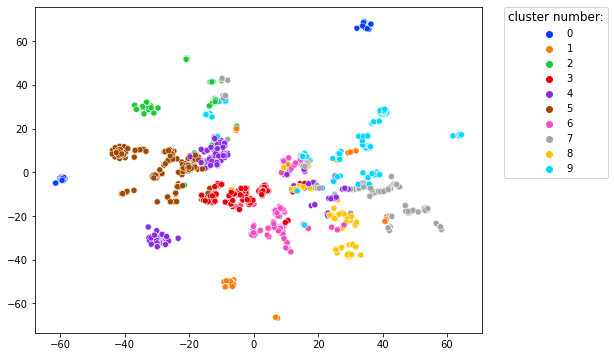

In [44]:
data_with_lost.rete.project(method='tsne', plot_type='clusters');

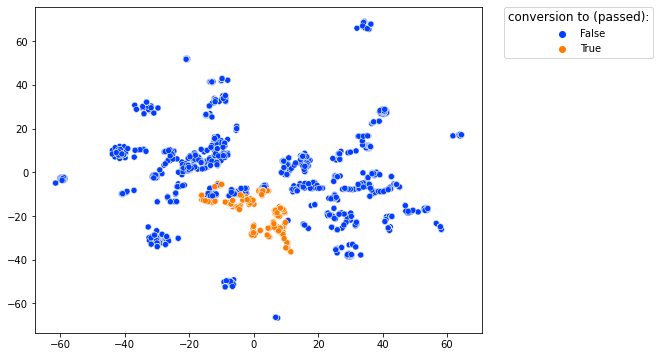

In [45]:
data_with_lost.rete.project(method='tsne', 
                  plot_type='targets',
                  targets=['passed']);

Построим граф для нескольких кластеров

In [46]:
#самый конверсионный кластер
data_with_lost.rete.filter_cluster(5).rete.plot_graph(
                     norm_type=None,
                     targets={'passed':'green',
                              'lost':'red',
                              'facebook':'source',
                              'blog':'source'
                               },
                     thresh=30,
                    );

In [48]:
#9 кластер тоже с высокой конверсией
data_with_lost.rete.filter_cluster(6).rete.plot_graph(
                     norm_type=None,
                     targets={'passed':'green',
                              'lost':'red',
                              'facebook':'source',
                              'blog':'source'
                               },
                     thresh=30,
                    );

In [49]:
data_with_lost.rete.filter_cluster(9).rete.plot_graph(
                     norm_type=None,
                     targets={'passed':'green',
                                'lost':'red',
                              'facebook':'source',
                              'blog':'source'
                               },
                     thresh=0,
                    );

Тут прям с первой секунды видно - куча людей из фейсбука уходят, после того как зашли на раздел доставки. И видно что таких людей дофига. Можно смело детальнее анализировать этот кейс

Исследуем профиль этого кластера - какие события как часто вызывались пользователями этого кластера

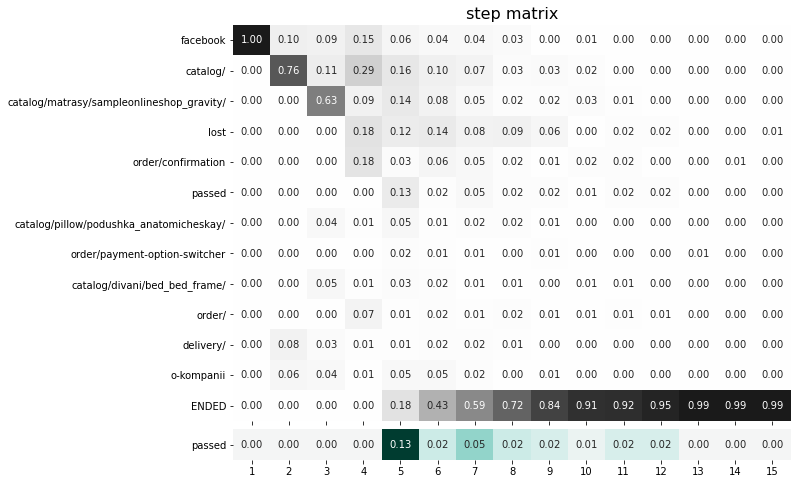

In [39]:
step_matrix_9 = data_with_lost.rete.filter_cluster(9).rete.step_matrix(max_steps=15,
                                  targets=['passed'])

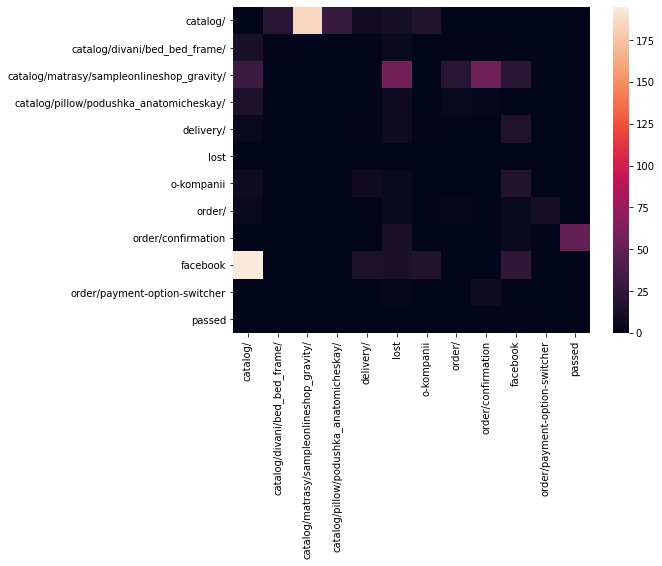

In [40]:
sns.heatmap(data_with_lost.rete.filter_cluster(9).rete.get_adjacency());

Более детальное рассмотрение Топ-10 событий кластера и сравнение со всеми пользователями всех кластеров

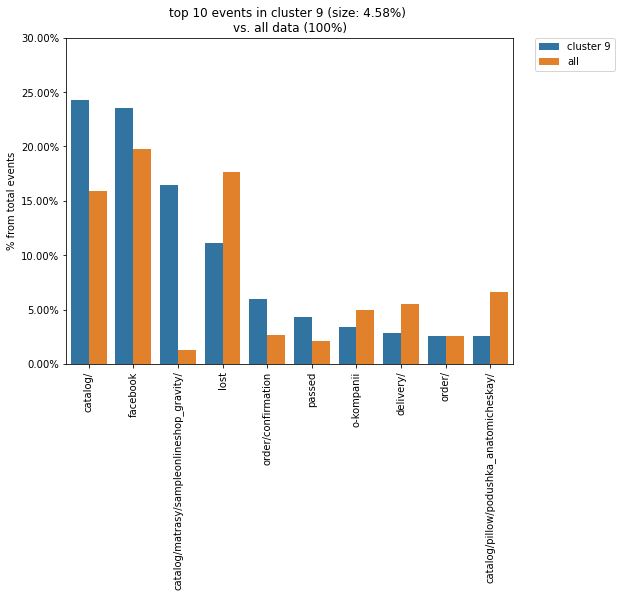

In [41]:
data_with_lost.rete.cluster_event_dist(9, top_n=10)

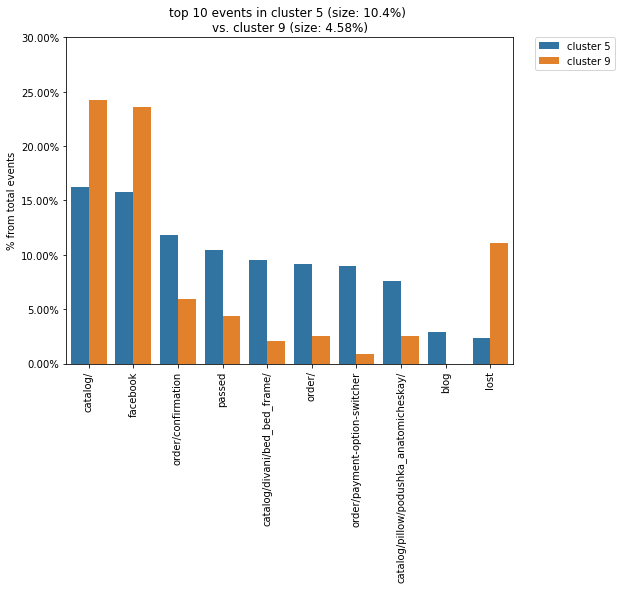

In [42]:
data_with_lost.rete.cluster_event_dist(5,9, top_n=10)

## Кластеризация Н-грам длины 2

Расширим N-граммы длины 1 до N-грамм длины 2: учтём переходы

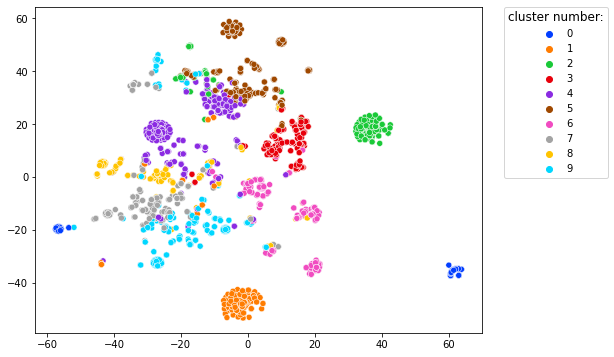

In [52]:
data_with_lost.rete.project(plot_type='clusters', ngram_range=(1, 2));

Сколько у нас уникальных событий:

In [44]:
data['event_name'].nunique()

12

Сколько уникальных переходов:

In [45]:
edgelist = data.rete.get_edgelist()
edgelist.shape[0]

50

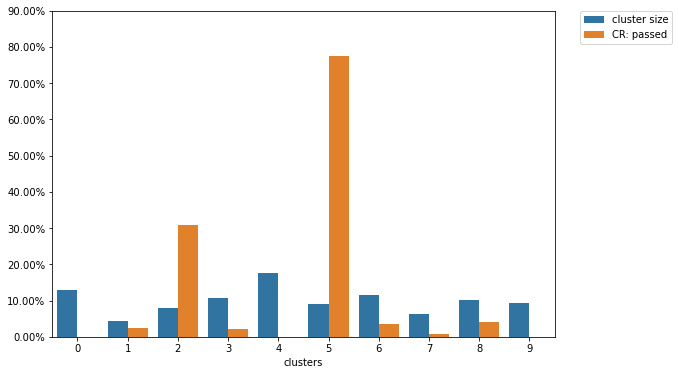

In [46]:
data.rete.get_clusters(n_clusters=10,
                       plot_type='cluster_bar',
                       targets=['passed'],
                       ngram_range=(1, 2));

In [54]:
data.rete.project(plot_type='clusters', ngram_range=(1, 1));

AttributeError: Run .rete.get_clusters() before using plot_type='clusters' to obtain clusters mapping

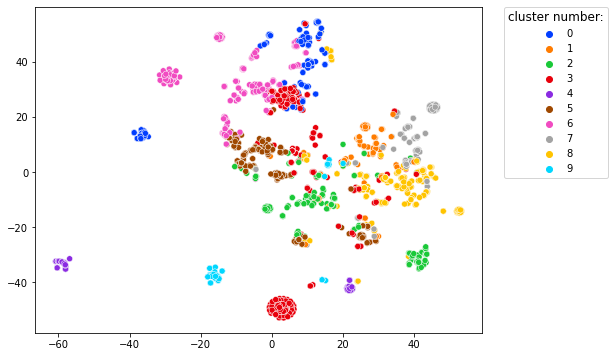

In [47]:
data.rete.project(plot_type='clusters', ngram_range=(1, 2));

In [56]:
data.rete.project(plot_type='clusters', ngram_range=(1, 3));

AttributeError: Run .rete.get_clusters() before using plot_type='clusters' to obtain clusters mapping